# Optimizing Hyperparameters

Some input parameters of a quantum program are directly connected to the problem being solved. For instance, there might be a parameter describing a length of some list of numbers being processed. Or a parameter corresponding to some physical property of a molecule that you are trying to simulate. On the other hand, some other parameters can be tweaked without affecting the input problem. For instance in typical QROM implementation, parameter $\lambda$ describes a tradeoff between circuit depth and qubit highwater. Such paramters might be subject to optimization, which we will demonstrate in this part of the tutorial.

We will start by loading a QREF file with an already compiled double factorization routine.

In [60]:
from bartiq import CompiledRoutine, sympy_backend, evaluate
import yaml

with open("../../data/double_factorization_compiled.yaml", "r") as f:
    compiled_routine = CompiledRoutine.from_qref(yaml.safe_load(f), sympy_backend)

We will now fix all the routine input parameters related to the input problem, which essentially leaves only parameter $\lambda$ free (to not clash with builtin `lambda` keyword, the parameter is actually called `lamda`).

In [62]:
assignments = {
    "N_spatial": 35,
    "M_r": 7590 // 298,
    "R": 298,
    "b_as": 10,
    "b_mas": 10,
    "b_givens": 20
}
df = evaluate(compiled_routine, assignments=assignments).routine

For our example, we will find the value of `lamda` that minimizes the active volume of our routine. Let's first take a look at the expression that we want to minimize!

In [63]:
active_volume = df.resource_values["active_volume"]
active_volume

83436*lamda + (ceiling(0.75*lamda) + 49)*Max(0, ceiling(298/lamda) - 1) + (ceiling(0.75*lamda) + 49)*Max(0, ceiling(299/lamda) - 1) + (4*ceiling(0.75*lamda) + 196)*Max(0, ceiling(7450/lamda) - 1) + (2*ceiling(14.25*lamda) + 98)*Max(0, ceiling(7450/lamda) - 1) + (ceiling(22.5*lamda) + 49)*Max(0, ceiling(298/lamda) - 1) + (2*ceiling(510.0*lamda) + 98)*Max(0, ceiling(7450/lamda) - 1) + 305511.5

Nice! Indeed, our active_volume now depends only on `lamda`. Before we optmize it, let's note that lambda is typically restricted to be an integral power of two. Therefore, the smallest `lamda` we can have is 1.

How do we minimize `active_volume`? Bartiq contains a built-in optimization module. It currently only supports continuous variables, so we'll temporarily forget the assumption about `lambda` being equal to 2. Here's how to use Bartiq's `minimize` function:

In [77]:
from bartiq.analysis.optimization import minimize

result = minimize(
    df.resource_values["active_volume"],  # An expression to be optimized
    param="lamda",                        # Name of the free variable in the expression
    optimizer="scipy",                    # Can either use scipy or "gradient-descent"
    optimizer_kwargs={                    # Params passed to the optimizer, common to all optimizers
        "x0": 4,                         # x0: start optimization from lamda=4
        "bounds": (1, None),              # Search in the interval [1, +infty)
        "max_iter": 1000                  # Perform maximum of 1000 iterations
    },
    scipy_kwargs={
        "method": "Nelder-mead"           # Scipy specific param - use "Nelder-mead" as optimization method
    }
)

f"opt. lamda = {result['optimal_value']}, opt. active_volume = {result['minimum_cost']}"

Optimization terminated successfully.
         Current function value: 9139555.207684
         Iterations: 43
         Function evaluations: 93


'opt. lamda = 6.0177705988288, opt. active_volume = 9139555.20768388'

The optimization was technically successful, but the optimal value of `lamda` is not a power of two. While we may check nearby power of 2s and choose the one minimizing active volume, there is no guarantee that this is indeed a global optimum.

However, in our example, taking closer look at the expression allows us to actually find the global minimum by the means of exhaustive search. To do this, we'll instantiate an expression_rewriter and add an assumption that `lamda >= 1` to get rid of all those pesky `Max`imums.

In [85]:
from bartiq.analysis import sympy_rewriter

rewriter = sympy_rewriter(active_volume).assume("lamda >= 1")
rewriter

SympyExpressionRewriter(expression=83436*lamda + (ceiling(298/lamda) - 1)*(ceiling(0.75*lamda) + 49) + (ceiling(298/lamda) - 1)*(ceiling(22.5*lamda) + 49) + (ceiling(299/lamda) - 1)*(ceiling(0.75*lamda) + 49) + (ceiling(7450/lamda) - 1)*(4*ceiling(0.75*lamda) + 196) + (ceiling(7450/lamda) - 1)*(2*ceiling(14.25*lamda) + 98) + (ceiling(7450/lamda) - 1)*(2*ceiling(510.0*lamda) + 98) + 305511.5, _original_expression=83436*lamda + (ceiling(0.75*lamda) + 49)*Max(0, ceiling(298/lamda) - 1) + (ceiling(0.75*lamda) + 49)*Max(0, ceiling(299/lamda) - 1) + (4*ceiling(0.75*lamda) + 196)*Max(0, ceiling(7450/lamda) - 1) + (2*ceiling(14.25*lamda) + 98)*Max(0, ceiling(7450/lamda) - 1) + (ceiling(22.5*lamda) + 49)*Max(0, ceiling(298/lamda) - 1) + (2*ceiling(510.0*lamda) + 98)*Max(0, ceiling(7450/lamda) - 1) + 305511.5, backend=<bartiq.symbolics.sympy_backend.SympyBackend object at 0x7f02d0d28f50>, linked_symbols={}, _previous=(Assumption(symbol_name='lamda', comparator='>=', value=1), SympyExpressionRewr

Now let's examine all the individual terms.

In [86]:
rewriter.individual_terms

(305511.500000000,
 83436*lamda,
 (ceiling(298/lamda) - 1)*(ceiling(0.75*lamda) + 49),
 (ceiling(298/lamda) - 1)*(ceiling(22.5*lamda) + 49),
 (ceiling(299/lamda) - 1)*(ceiling(0.75*lamda) + 49),
 (ceiling(7450/lamda) - 1)*(2*ceiling(14.25*lamda) + 98),
 (ceiling(7450/lamda) - 1)*(2*ceiling(510.0*lamda) + 98),
 (ceiling(7450/lamda) - 1)*(4*ceiling(0.75*lamda) + 196))

Remarkably, aside from two first terms, all other terms are of the form:
$$
term = \left(\left\lceil\frac{const}{\lambda}\right\rceil-1\right) \cdot f(\lambda)
$$
with different constants in the ceiling function and dfifferent factor $f$. All those vanish for $\lambda > 7450$. For $\lambda > 7450$ our function is strictly increasing. So, we need to consider only the values of $\lambda$ smaller or equal to the first power of two above 7450, i.e. no larger than $2^{14} = 8192$. There's only 14 values, and we can brute-force them!

In [90]:
def av_func(lamda):
    return sympy_backend.substitute(active_volume, {"lamda": lamda})

possible_values = [(av_func(2 ** exp), 2 ** exp) for exp in range(0, 15)]
possible_values

opt_av, opt_lamda = min(possible_values)
opt_av, opt_lamda

(9182066.5, 8)

For completeness, we can also plot the value of active volume for different exponents.

Text(0, 0.5, 'active_volume($\\lambda=2^n$)')

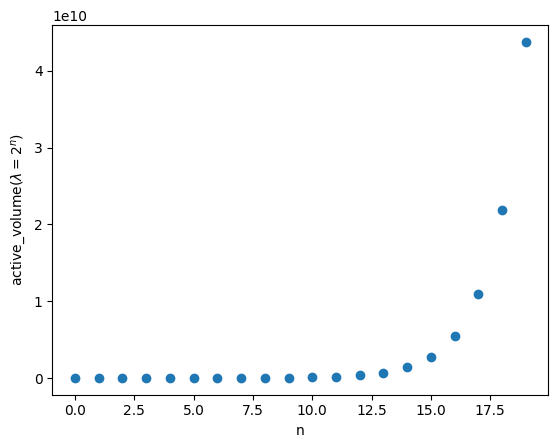

In [98]:
from matplotlib import pyplot as plt
exps = list(range(0, 20))  # We'll plot some more than we have to
values = [av_func(2 ** exp) for exp in exps]

plt.scatter(exps, values)
plt.xlabel("n")
plt.ylabel("active_volume($\\lambda=2^n$)")

## Key takeways:
- Some parameters in quantum programs are hyperparameters - knobs that can be tuned to optimize some target metrics.
- Bartiq contains a built-in optimization module. However, it only works for continuous variables. If you use it for discrete variables, you can treat it only as some approximation of the optimal solution.
- Bartiq's rewriters can help you gain insight into the expressions being optimized, which may lead to finding a global optimum even if the variable intolved in the optimization is discreete.